In [6]:
%load_ext autoreload
%autoreload 2

from disruption_survival_analysis.Experiments import Experiment
from disruption_survival_analysis.plot_experiments import plot_auroc_timeslice_all_vs_horizon, plot_auroc_timeslice_shot_avg_vs_horizon, plot_warning_time_vs_false_alarm_rate
from disruption_survival_analysis.plot_experiments import plot_risk_compare_models, plot_ettd_compare_models
from disruption_survival_analysis.experiment_utils import load_experiment_config
import pandas as pd
from IPython.display import display

device = 'synthetic'
dataset_path = 'synthetic100'
#device = 'cmod'
#dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive'

# Load models and create experiments

# models, alarms, metrics, and minimum warning times to use
models = ['cph']
alarms = ['sthr']
metrics = ['auroc']
min_warning_times = [0.1]

# Create a list of experiments
experiment_list = []
for model in models:
    for alarm in alarms:
        for metric in metrics:
            for min_warning_time in min_warning_times:
                
                config = load_experiment_config(device, dataset_path, model, alarm, metric, min_warning_time)
                
                # Create test experiment from config
                experiment = Experiment(config, 'test')
                experiment_list.append(experiment)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Saved model to models/synthetic/synthetic100/cph_sthr_auroc_100ms.pkl


## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

Two trends can be seen:
1. The survival models perform considerably better at longer horizons.
2. The survival models do not benefit as much as the binary classifiers from having temporal data of previous timeslices included in the feature list.

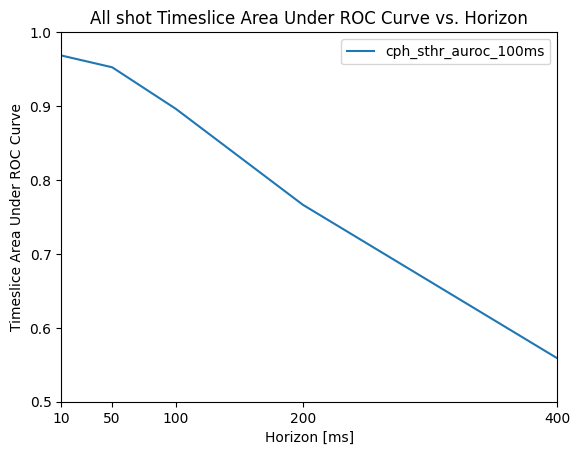

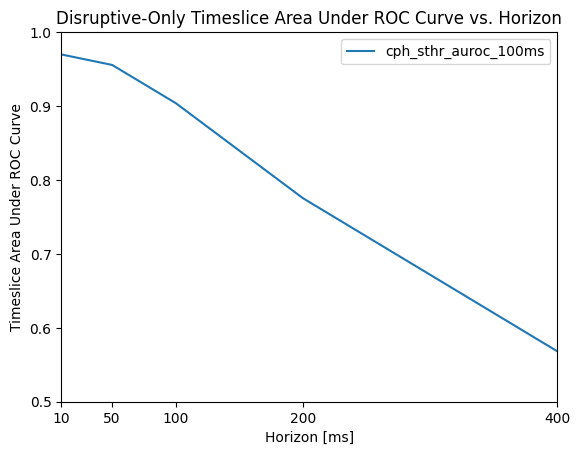

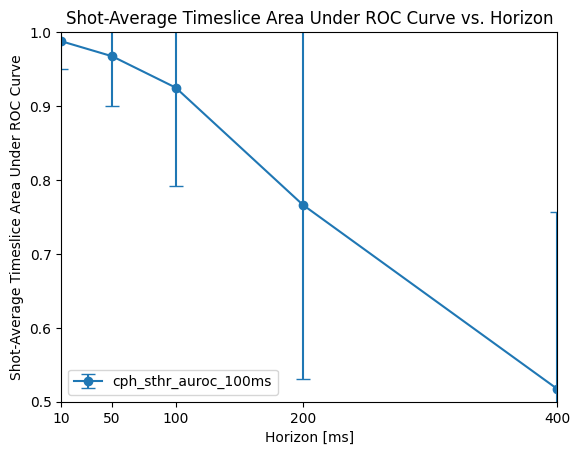

In [7]:
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=False)
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=True)
plot_auroc_timeslice_shot_avg_vs_horizon(experiment_list)


## Table of Metrics:

In [4]:
required_warning_time = 0.02

result_data = []

#plot_TAR_vs_FAR(experiment_list, required_warning_time=required_warning_time)
#plot_warning_time_vs_FAR(experiment_list, required_warning_time=required_warning_time)

for experiment in experiment_list:
    auroc = experiment.evaluate_metric('auroc', required_warning_time=required_warning_time)
    auwtc = experiment.evaluate_metric('auwtc', required_warning_time=required_warning_time)
    maxf1 = experiment.evaluate_metric('maxf1', required_warning_time=required_warning_time)
    tar, far, avg_warn, std_warn = experiment.max_f1_info(required_warning_time=required_warning_time)
    
    result_array = [experiment.name, auroc, auwtc*1000, maxf1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Experiment Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
print(f"Model Performance when Reqired Warning Time is {required_warning_time*1000} ms")
display(result_df)

TypeError: only integer scalar arrays can be converted to a scalar index

## Area Under Warning Time Curve



c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\disruption_survival_analysis\plot_experiments.py:159: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim([min_far, max_far])


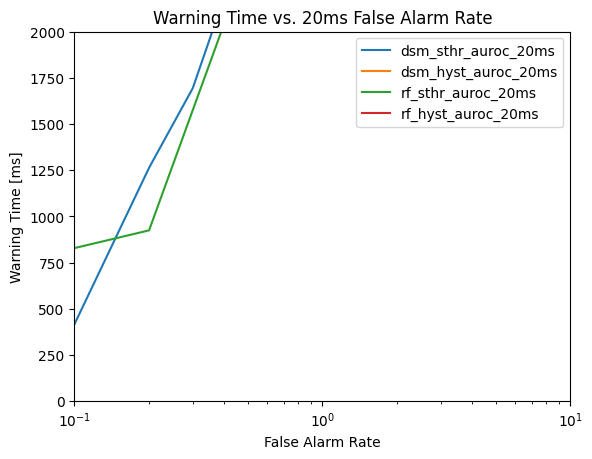

In [7]:
plot_warning_time_vs_false_alarm_rate(experiment_list)

# One Model Type (several individual models)

Risk and ETTD plotted against what it should look like

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\disruption_survival_analysis\DisruptionPredictors.py:305: RuntimeWarning: divide by zero encountered in scalar divide
  ettd = (1 / risk) * self.trained_disruptive_window
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\disruption_survival_analysis\DisruptionPredictors.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ettd_at_times.iloc[i]['ettd'] = ettd
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\disruption_survival_analysis\DisruptionPredictors.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

KeyError: "['ettd'] not in index"

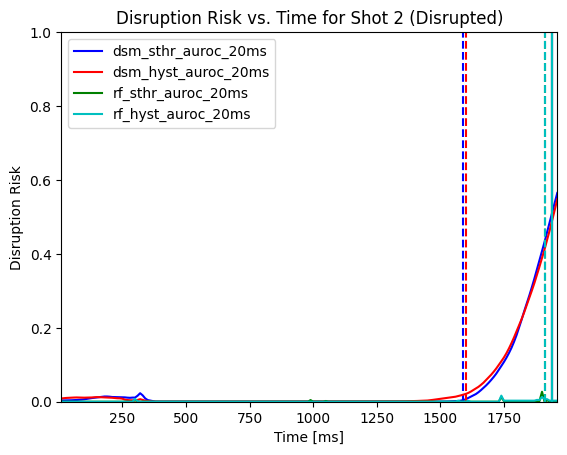

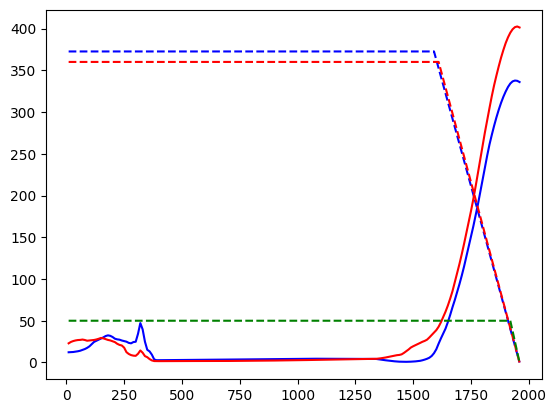

In [4]:
shot_number = experiment_list[0].get_disruptive_shot_list()[0]
plot_risk_compare_models(experiment_list, shot_number)
plot_ettd_compare_models(experiment_list, shot_number)

shot_number = experiment_list[0].get_non_disruptive_shot_list()[0]
plot_risk_compare_models(experiment_list, shot_number)
plot_ettd_compare_models(experiment_list, shot_number)

In [5]:
#plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])